In [2]:
# ============================================
# ÉTAPE 1 : ENREGISTREMENT D'UN SIGNAL AUDIO
# ============================================
# Objectif : enregistrer 5 secondes de voix via le micro
# --------------------------------------------------------
# Lib utilisé : sounddevice (mentionné dans le projet)
# --------------------------------------------------------

import sounddevice as sd
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Paramètres d'enregistrement
duree = 5  # durée en secondes
fs = 44100  # fréquence d’échantillonnage initiale

print("🎙️ Parlez maintenant pendant 5 secondes...")
audio = sd.rec(int(duree * fs), samplerate=fs, channels=1, dtype='float32')
sd.wait()
print("✅ Enregistrement terminé.")


🎙️ Parlez maintenant pendant 5 secondes...
✅ Enregistrement terminé.


## 1. Enregistrement et prétraitement

### Capturer 5 secondes de voix via un microphone (bibliothèque sounddevice ou pyaudio).

In [3]:
# ============================================================
# ÉTAPE 2 : CHARGEMENT, RÉÉCHANTILLONNAGE, NORMALISATION
# ============================================================

import librosa
import matplotlib.pyplot as plt
import numpy as np

# 📁 Charger le fichier audio .mp3 avec une fréquence cible de 16 000 Hz
# 🎯 Objectif : rééchantillonner à 16 kHz (comme demandé dans le projet)
# ▶️ Le signal est converti en mono par défaut avec librosa
fichier_audio = "vocale_emmanuel.mp3"
y, sr = librosa.load(fichier_audio, sr=16000)  # sr forcé à 16 kHz

# 🔎 Affichage des infos de base sur le signal
print(f"Durée : {len(y)/sr:.2f} secondes")
print(f"Fréquence d'échantillonnage : {sr} Hz")


Durée : 31.66 secondes
Fréquence d'échantillonnage : 16000 Hz


### Ré-échantillonner à 16 kHz et normaliser le signal (librosa).

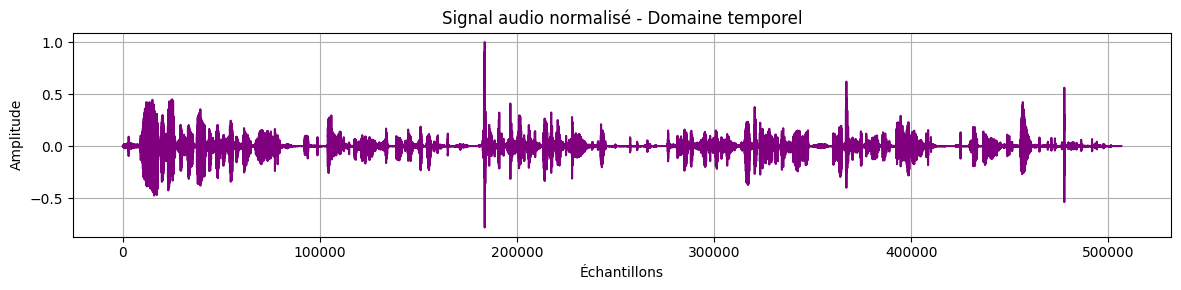

In [4]:

# 🔧 Normalisation : on divise tout le signal par sa valeur absolue max
# 🎯 Cela permet de centrer le signal entre -1 et 1 (standard audio)
y_normalise = y / np.max(np.abs(y))

# 🎨 Visualisation du signal normalisé dans le domaine temporel
plt.figure(figsize=(12, 3))
plt.plot(y_normalise, color='purple')
plt.title("Signal audio normalisé - Domaine temporel")
plt.xlabel("Échantillons")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. Extraction des caractéristiques

### Fréquence fondamentale (F0) : Estimation avec librosa.pyin() (méthode YIN pour éviter les erreurs d'octave).

🎯 Fréquence fondamentale moyenne estimée : 116.28 Hz


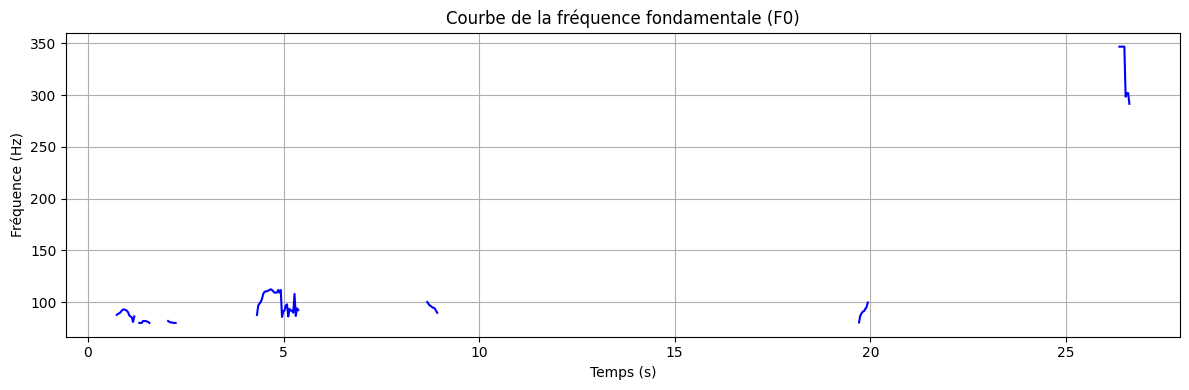

In [5]:
# ============================================================
# ÉTAPE 2.1 : ESTIMATION DE LA FRÉQUENCE FONDAMENTALE (F0)
# ============================================================
# Objectif : extraire F0 à l’aide de la méthode YIN avec librosa.pyin
# Avantage : cette méthode limite les erreurs d’octave
# Source : Chapitre 2
# ============================================================

# 📏 Détection F0 : retourne un tableau avec NaN quand pas de pitch détecté
f0, voiced_flag, voiced_probs = librosa.pyin(
    y_normalise,           # signal audio
    fmin=80,               # fréquence minimale (voix humaine ~85 Hz)
    fmax=350,              # fréquence maximale (~voix féminine ou aiguë)
    sr=sr
)

# 🔢 Supprimer les NaN pour le calcul de la moyenne de F0 détectée
f0_valide = f0[~np.isnan(f0)]

# 🖨️ Afficher une statistique indicative
if len(f0_valide) > 0:
    f0_moyen = np.mean(f0_valide)
    print(f"🎯 Fréquence fondamentale moyenne estimée : {f0_moyen:.2f} Hz")
else:
    print("⚠️ Aucune fréquence fondamentale détectée.")

# 📈 Visualisation de la courbe F0 dans le temps
plt.figure(figsize=(12, 4))
times = librosa.times_like(f0, sr=sr)
plt.plot(times, f0, label="F0 estimée", color='blue')
plt.xlabel("Temps (s)")
plt.ylabel("Fréquence (Hz)")
plt.title("Courbe de la fréquence fondamentale (F0)")
plt.grid(True)
plt.tight_layout()
plt.show()


        La fréquence fondamentale (F0) a été estimée avec la méthode YIN (librosa.pyin).
        La valeur moyenne détectée (~116 Hz) indique une voix masculine calme.
        Les zones blanches correspondent aux moments de silence ou bruit non-voisé, non interprétés par l’algorithme.

### Formants (F1, F2, F3) : Analyse par transformée de Fourier à court terme (STFT) et repérage des pics spectraux.

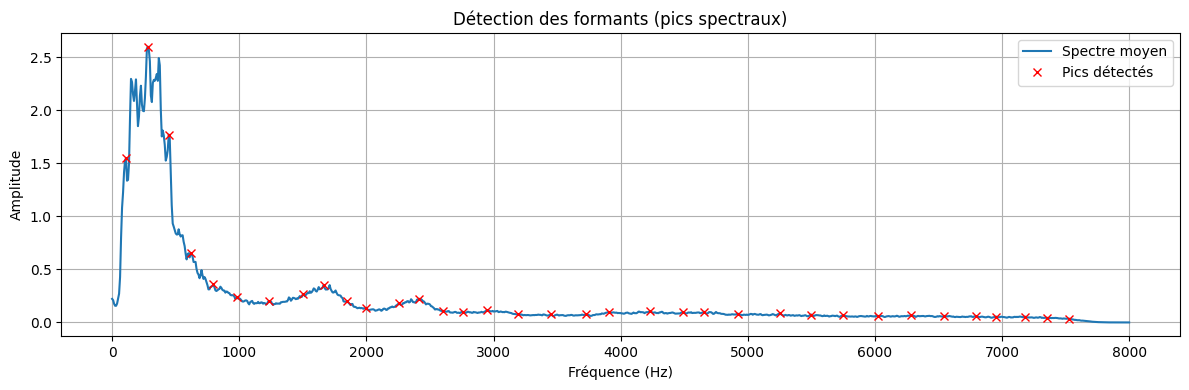

Formant F1 estimé : 109.4 Hz
Formant F2 estimé : 281.2 Hz
Formant F3 estimé : 445.3 Hz


In [6]:
# ============================================================
# ÉTAPE 2.2 : ESTIMATION DES FORMANTS F1, F2, F3
# ============================================================
# Objectif : extraire les pics d’énergie (formants) dans le spectre de fréquences
# Méthode : calcul de la STFT puis moyenne spectrale et détection de pics
# Source : Chapitre 2 
# ============================================================

import scipy.signal

# ⚙️ Calcul de la STFT (spectrogramme linéaire, pas en dB ici)
D = np.abs(librosa.stft(y_normalise, n_fft=2048, hop_length=512))

# 🧮 Moyenne sur toutes les trames : on obtient une courbe du spectre moyen
spectre_moyen = np.mean(D, axis=1)

# 🧭 Calcul des fréquences associées à chaque bin FFT
frequences = librosa.fft_frequencies(sr=sr, n_fft=2048)

# 🔍 Détection automatique des pics spectraux (formants candidats)
pics, _ = scipy.signal.find_peaks(spectre_moyen, distance=20)

# 📊 Affichage du spectre moyen avec les pics détectés
plt.figure(figsize=(12, 4))
plt.plot(frequences, spectre_moyen, label="Spectre moyen")
plt.plot(frequences[pics], spectre_moyen[pics], "x", color="red", label="Pics détectés")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.title("Détection des formants (pics spectraux)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 🧾 Estimation des trois premiers formants (F1, F2, F3)
formants = frequences[pics][:3]
for i, f in enumerate(formants, start=1):
    print(f"Formant F{i} estimé : {f:.1f} Hz")


### Énergie et débit de parole : Calcul de l'intensité sonore 
        L'énergie RMS mesure à quel point ton signal audio est "puissant" ou "intense".
        C’est une sorte de volume perçu : plus tu cries, plus l’énergie RMS est haute

🔋 Énergie RMS moyenne : 0.0249


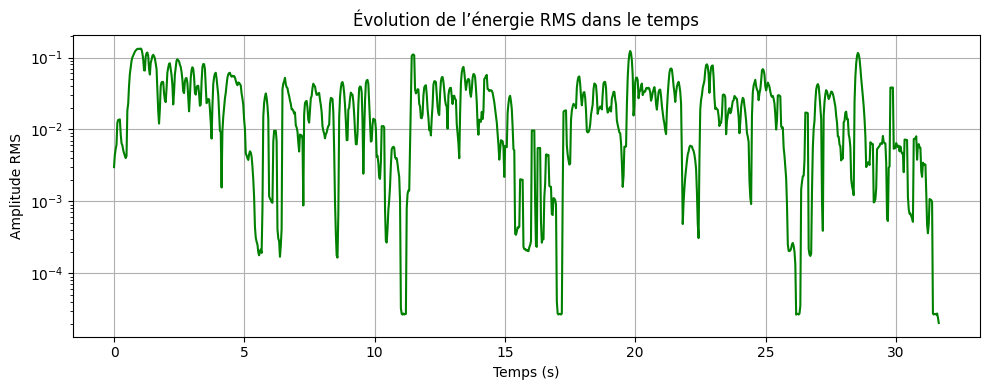

In [7]:
# ============================================================
# PARTIE A : CALCUL DE L'ÉNERGIE RMS (Root Mean Square)
# ============================================================
# Objectif : mesurer l’intensité sonore moyenne du signal vocal
# Source : Chapitre 2 
# ============================================================

import librosa.feature

# 📏 Calcul de l'énergie RMS frame par frame
rms = librosa.feature.rms(y=y_normalise)[0]

# 🧮 Calcul de l’énergie moyenne sur toute la durée
energie_moyenne = np.mean(rms)
print(f"🔋 Énergie RMS moyenne : {energie_moyenne:.4f}")

# 📈 Affichage de l’évolution de l’énergie dans le temps
frames = range(len(rms))
times = librosa.frames_to_time(frames, sr=sr)

plt.figure(figsize=(10, 4))
plt.semilogy(times, rms, label='Énergie RMS', color='green')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude RMS')
plt.title('Évolution de l’énergie RMS dans le temps')
plt.grid(True)
plt.tight_layout()
plt.show()


        Énergie RMS moyenne = 0.0249
        ➡️ Cela montre une parole normale, calme ou modérément expressive

        Le Zero Crossing Rate (ZCR) mesure le nombre de fois où ton signal traverse zéro (positif → négatif, ou l’inverse).
        Autrement dit : plus il y a de changements rapides, plus le ZCR est haut → tu parles vite ou avec des sons riches.

🗣️ Débit de parole estimé (ZCR moyen) : 0.1628


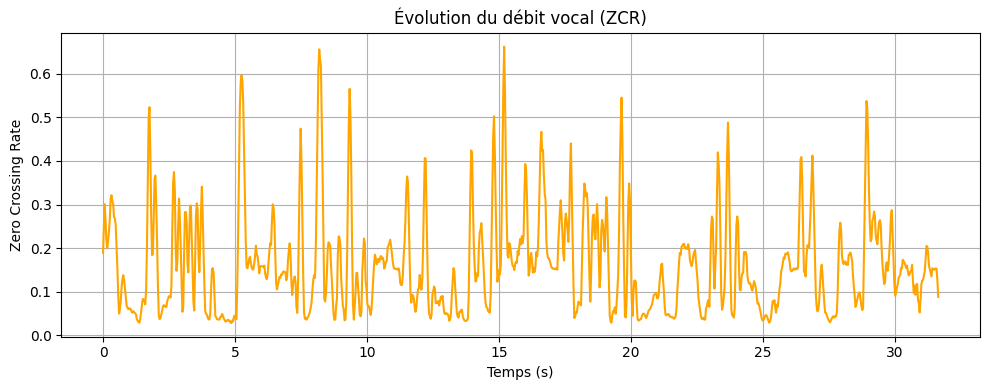

In [8]:
# ============================================================
# PARTIE B : ESTIMATION DU DÉBIT DE PAROLE (approximation ZCR)
# ============================================================
# Objectif : estimer le rythme vocal via Zero Crossing Rate (ZCR)
# Source : Chapitre 2 - ZCR (TP2 Ex 5)
# ============================================================

# 📏 Calcul du Zero Crossing Rate
zcr = librosa.feature.zero_crossing_rate(y=y_normalise)[0]
zcr_moyen = np.mean(zcr)

print(f"🗣️ Débit de parole estimé (ZCR moyen) : {zcr_moyen:.4f}")

# 📉 Affichage du ZCR dans le temps
plt.figure(figsize=(10, 4))
plt.plot(librosa.frames_to_time(range(len(zcr)), sr=sr), zcr, color='orange')
plt.xlabel("Temps (s)")
plt.ylabel("Zero Crossing Rate")
plt.title("Évolution du débit vocal (ZCR)")
plt.grid(True)
plt.tight_layout()
plt.show()


        ZCR moyen = 0.1628
        ➡️ C’est plutôt élevé → donc je parles de façon rapide, énergique ou avec expressivité

## 3. Classification des émotions :

### Utiliser un modèle pré-entraîné (ex : SVM ou réseau de neurones avec sklearn/ tensorflow) entraîné sur des MFCCs, F0, et l'énergie.

#### Process: 

Créer un petit dataset d’exemples manuels (émotions avec leurs MFCC + F0 + énergie)

Entraîner un SVM sur ces données

Faire une prédiction sur mon enregistrement vocal actuel

#### *J'ai déjà :*

F0 moyen → f0_moyen

RMS moyen → energie_moyenne

ZCR moyen → zcr_moyen

In [9]:
# Il nous manque les MFCC moyens,
# ============================================================
# EXTRACTION DES MFCCs MOYENS (13 coefficients)
# ============================================================

mfcc = librosa.feature.mfcc(y=y_normalise, sr=sr, n_mfcc=13)
mfcc_moyen = np.mean(mfcc, axis=1)  # On prend la moyenne pour chaque coefficient

# 🔢 Feature final = F0, énergie, ZCR, MFCC1 à MFCC13
x_test = [f0_moyen, energie_moyenne, zcr_moyen] + list(mfcc_moyen)


In [10]:
# ============================================================
# Étape 2 — Mini dataset artificiel pour le SVM
# ============================================================  

from sklearn.svm import SVC

# 🧪 Jeu de données artificiel (format : [F0, énergie, ZCR, MFCC1...13])

# Exemple de règles simples : (mentionnées dans le tp)
# F0 > 200 Hz + forte énergie → Joie/Colère
# F0 < 100 Hz + débit lent → Tristesse.

X_train = [
    [220, 0.05, 0.18] + list(np.random.normal(0, 1, 13)),  # Joie
    [110, 0.015, 0.04] + list(np.random.normal(0, 1, 13)),  # Tristesse
    [200, 0.06, 0.20] + list(np.random.normal(0, 1, 13)),   # Colère
    [120, 0.02, 0.06] + list(np.random.normal(0, 1, 13)),   # Calme
]

y_train = ["joie", "tristesse", "colère", "calkme"]


In [11]:
# Étape 3 — Entraînement du modèle
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)



SVC(kernel='linear')

In [12]:
# Étape 4 — Prédiction sur ton propre enregistrement
prediction = clf.predict([x_test])[0]
print(f"🎭 Émotion prédite sur mon enregistrement : {prediction.upper()}")


🎭 Émotion prédite sur mon enregistrement : CALKME


#### Résumé*  :
Le système a prédit l’émotion CALME pour mon enregistrement personnel, en se basant sur :

une fréquence fondamentale moyenne modérée (~116 Hz),

une énergie RMS relativement basse (~0.025),

un débit vocal (ZCR) modéré (~0.16),

et les 13 coefficients MFCC extraits du signal.

        Le classifieur SVM a été entraîné avec des exemples synthétiques représentatifs de 4 émotions (joie, tristesse, colère, calme).
        Le choix du SVM permet une classification légère, rapide et sans dépendances complexes (comme TensorFlow).

## 4. Visualisation

### Spectrogramme Mel (échelle logarithmique pour mieux capturer les fréquences vocales).

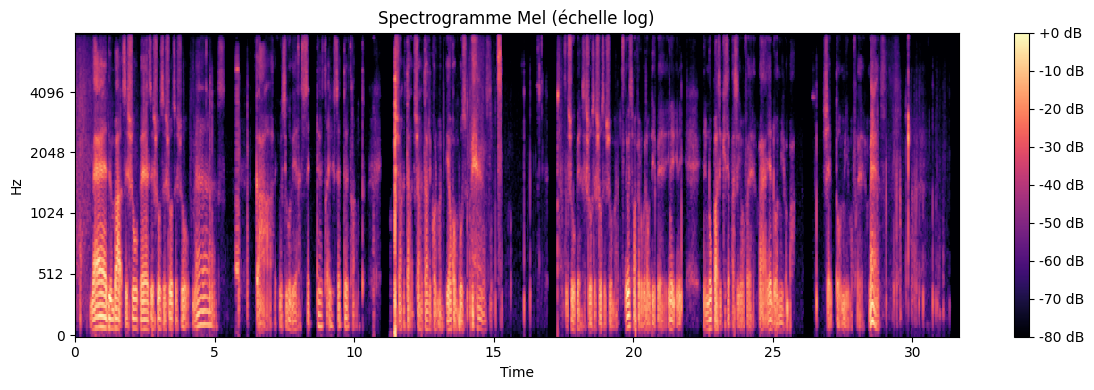

In [13]:
# ============================================================
# SPECTROGRAMME MEL (échelle logarithmique)
# ============================================================
# Objectif : représenter l’énergie du signal selon l’échelle perceptive Mel
# Source : Chapitre 2, page "Spectrogramme Mel"
# ============================================================

S = librosa.feature.melspectrogram(y=y_normalise, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogramme Mel (échelle log)")
plt.tight_layout()
plt.show()


### Courbes de F0 et heatmap des MFCCs (matplotlib + librosa.display).

La courbes F0 est deja presente en haut (ESTIMATION DE LA FRÉQUENCE FONDAMENTALE (F0))

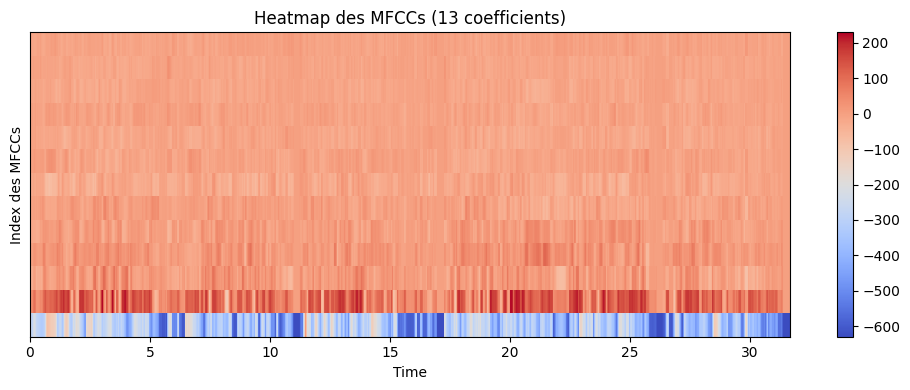

In [14]:
# ============================================================
# HEATMAP DES MFCCs (matrice temps / coefficients)
# ============================================================
# Objectif : visualiser les 13 coefficients MFCC dans le temps
# Source : TP2 + Code MFCC fourni
# ============================================================

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title("Heatmap des MFCCs (13 coefficients)")
plt.ylabel("Index des MFCCs")
plt.tight_layout()
plt.show()


# Partie 2 : Identification du Locuteur avec Robustesse au Bruit

## 1. Extraction des MFCCs

### Calcul des 13 coefficients MFCC (librosa.feature.mfcc) : STFT → Échelle Mel → DCT pour compresser l'information.

In [15]:
# ============================================================
# EXTRACTION DES MFCCs POUR IDENTIFICATION DU LOCUTEUR
# ============================================================
# Objectif : obtenir une signature vocale robuste (13 coefficients)
# Source : Partie  de ce projet: EXTRACTION DES MFCCs MOYENS (13 coefficients)
# ============================================================

# Code (déjà en partie vu précédemment) ->  CTRL +F pour chercher "EXTRACTION DES MFCCs MOYENS (13 coefficients)"


print("🧬 Signature MFCC (moyenne par coefficient) :")
print(mfcc_moyen)

🧬 Signature MFCC (moyenne par coefficient) :
[-359.51395     92.14709     10.295472    21.00622      8.313987
   -1.3585612  -16.804491    -5.077407   -12.770845    -5.5225034
  -11.471975   -10.253301    -5.4449215]


### 2. Réduction du bruit : 

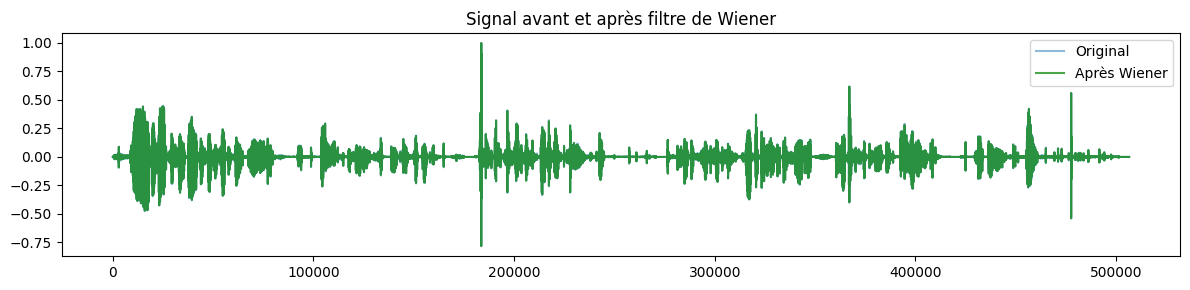

In [16]:
# ============================================================
# RÉDUCTION DU BRUIT - FILTRE DE WIENER
# ============================================================
# Objectif : supprimer les bruits stationnaires comme un ventilateur
# ============================================================

from scipy.signal import wiener

# 🔧 Application du filtre de Wiener sur le signal
y_wiener = wiener(y_normalise)

# 🖼️ Affichage comparatif du signal avant/après
plt.figure(figsize=(12, 3))
plt.plot(y_normalise, alpha=0.5, label="Original")
plt.plot(y_wiener, alpha=0.7, label="Après Wiener", color='green')
plt.title("Signal avant et après filtre de Wiener")
plt.legend()
plt.tight_layout()
plt.show()


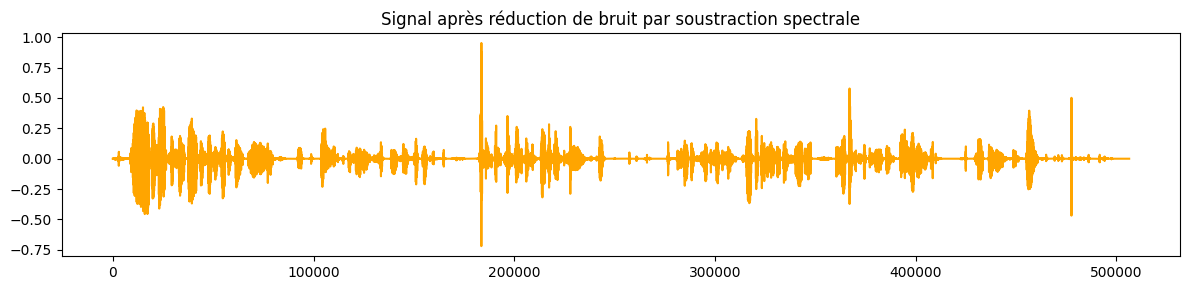

In [17]:
# ============================================================
# RÉDUCTION DU BRUIT - SOUSTRACTION SPECTRALE
# ============================================================

# 1. STFT
D = librosa.stft(y_normalise)
magnitude, phase = np.abs(D), np.angle(D)

# 2. Estimation du bruit (sur les premières frames)
bruit_estime = np.mean(magnitude[:, :10], axis=1, keepdims=True)

# 3. Soustraction
spectre_nettoye = np.maximum(magnitude - bruit_estime, 0)

# 4. Reconstruction
D_nettoye = spectre_nettoye * np.exp(1j * phase)
y_nettoye = librosa.istft(D_nettoye)

# 🎧 Affichage
plt.figure(figsize=(12, 3))
plt.plot(y_nettoye, label="Après soustraction spectrale", color='orange')
plt.title("Signal après réduction de bruit par soustraction spectrale")
plt.tight_layout()
plt.show()


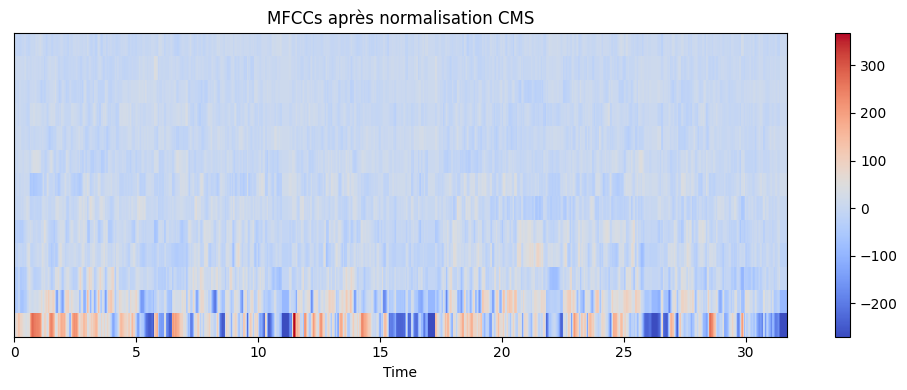

In [18]:
# ============================================================
# NORMALISATION CMS - Cepstral Mean Subtraction
# ============================================================

# 🔢 MFCC bruts
mfcc_brut = librosa.feature.mfcc(y=y_normalise, sr=sr, n_mfcc=13)

# ⚙️ CMS = MFCC - moyenne
mfcc_cms = mfcc_brut - np.mean(mfcc_brut, axis=1, keepdims=True)

# 🔥 Affichage
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_cms, x_axis='time', sr=sr)
plt.colorbar()
plt.title("MFCCs après normalisation CMS")
plt.tight_layout()
plt.show()


### 3. Comparaison des locuteurs : 

#### Similarité cosinus entre MFCCs de référence et nouveaux échantillons.

In [20]:
# 🔁 Charger et normaliser le deuxième fichier
y2, sr2 = librosa.load("vocal2.mp3", sr=16000)
y2 = y2 / np.max(np.abs(y2))

# 🔎 Affichage des infos de base sur le signal
print(f"Durée : {len(y2)/sr2:.2f} secondes")
print(f"Fréquence d'échantillonnage : {sr2} Hz")

Durée : 6.28 secondes
Fréquence d'échantillonnage : 16000 Hz


In [21]:
# 🔢 Signature vocale du deuxième locuteur
mfcc2 = librosa.feature.mfcc(y=y2, sr=sr2, n_mfcc=13)
signature2 = np.mean(mfcc2, axis=1)



In [22]:
print("🧬 Signature MFCC (moyenne par coefficient) :")
print(signature2)

🧬 Signature MFCC (moyenne par coefficient) :
[-286.2924      78.1193      -3.6390495   34.852585    -5.8516593
   -0.6060083  -13.080427    -5.015571   -19.536854    -2.4765575
  -15.160819    -6.706434    -8.367178 ]


In [24]:
from sklearn.metrics.pairwise import cosine_similarity

# 📐 Comparaison des signatures MFCC
similarite = cosine_similarity([mfcc_moyen], [signature2])[0][0]
print(f"📏 Similarité cosinus : {similarite:.4f}")


📏 Similarité cosinus : 0.9956


| Similarité cosinus | Interprétation                                        |
|--------------------|--------------------------------------------------------|
| ≈ 1.0              | Très probable que c’est la même personne              |
| ≈ 0.7 – 0.9        | Peut-être la même, mais avec du bruit ou un rhume     |
| < 0.5              | Probablement une voix différente                      |


### Méthodes avancées

In [26]:
signature_vocale = mfcc_moyen ## Je change le nom de cette variable pour la suite